# Load Data

In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import notebook
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

In [2]:
from tensorflow.keras.datasets import fashion_mnist

In [3]:
(x_train,_),(x_val,_) = fashion_mnist.load_data()

In [4]:
data = np.vstack([x_train, x_val])

In [5]:
data = (data.astype('float32') - 127.5) / 127.5

In [6]:
data = data.reshape(-1,784)

In [7]:
adam = Adam(learning_rate= 0.0002, beta_1= 0.5)

# Build model

In [8]:
from tensorflow.keras.layers import * 
from tensorflow.keras.models import Model, Sequential

In [9]:
def generator(dim_noise = 100):
    input = Input(dim_noise)
    x = Dense(7 * 7 * 256)(input)
    x = LeakyReLU(0.2)(x)
    x = Reshape((7,7,256))(x)
    
    x = Conv2DTranspose(128, kernel_size= (3,3), strides= 2, padding= 'same')(x) # 14
    
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(64, kernel_size= (4,4), strides= 2, padding= 'same')(x) # 28
    
    x = LeakyReLU(0.2)(x)
    x = Conv2D(1, kernel_size= (4,4), strides= 1, padding= 'same', activation= 'tanh')(x)
    x = Flatten()(x)
    return Model(input, x, name = 'generator_model')

def discriminator():
    input = Input(shape = (28 * 28))
    x = Reshape((28,28,1))(input)
    x = Conv2D(128, kernel_size = (5,5), strides = 2, padding = 'same')(x) # 14

    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(256, kernel_size = (5,5), strides = 2, padding = 'same')(x) # 14
   
    x = LeakyReLU(0.2)(x)
     
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation = 'sigmoid')(x)
    return Model(input, x, name = 'discriminator')
g = generator()
d = discriminator()

g.compile(loss= 'mse', optimizer = adam, metrics = ['acc'])
d.compile(loss= 'mse', optimizer = adam, metrics = ['acc'])

d.trainable = False

gan_model = Sequential([g, d])
gan_model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
gan_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_model (Functional  (None, 784)              1694145   
 )                                                               
                                                                 
 discriminator (Functional)  (None, 1)                 835329    
                                                                 
Total params: 2,529,474
Trainable params: 1,694,145
Non-trainable params: 835,329
_________________________________________________________________


In [10]:
def show_example(gan_model):
    noise = np.random.normal(size = (10,100))
    image_generate = gan_model.layers[0](noise).numpy().reshape(-1,28,28)
    plt.figure(figsize= (12,2))
    for i in range(10):
        plt.subplot(1,10,i + 1)
        plt.imshow(image_generate[i], interpolation='nearest', cmap='gray_r' )
        plt.axis('off')
    plt.show()

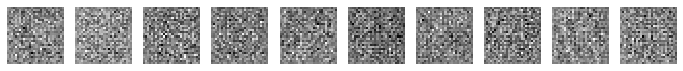

In [11]:
# test code
show_example(gan_model)

# Train

In [12]:
Loss_g, Loss_d = [], []
def train(gan_model, image, batch_size = 256, epochs = 100, verbose = 1):
    interation = int(len(image) / batch_size)
    for i in range(1, epochs + 1):
        if i % verbose == 0:
            print(f'Epochs {i}: ', end= '')
        indexes = np.arange(len(image))
        indexes = shuffle(indexes)
        fake_acc, real_acc = [], []
        loss_D, loss_G = [], []
        for j in notebook.tqdm(range(interation)):
            index = indexes[j * batch_size : (j + 1) * batch_size]
            real_img = np.array([image[k] for k in index])
            
            # sinh ảnh từ noise
            noise = np.random.normal(size = (batch_size, 100))
            fake_img = gan_model.layers[0](noise)
        
            # nhiễu label
            y = np.ones(batch_size * 2)
            y[:batch_size] = 0.9 # real_img
            y[batch_size:] = 0.1 # fake_img
            # train discriminator
            gan_model.layers[1].trainable = True
            # train real_img
            loss_real = gan_model.layers[1].train_on_batch(real_img,y[:batch_size])
            loss_fake = gan_model.layers[1].train_on_batch(fake_img,y[batch_size:])
            
            loss_d = 0.5 * np.add(loss_real, loss_fake)
            
            loss_D.append(loss_d)
            
            fake_acc.append(loss_fake[1])
            real_acc.append(loss_real[1])
            # train generator
            fake_img = np.random.normal(size = (batch_size, 100))
            y_fake = np.ones(batch_size)
            gan_model.layers[1].trainable = False
            loss_g = gan_model.train_on_batch(fake_img,y_fake)
            loss_G.append(loss_g)

        if i % verbose == 0:
            show_example(gan_model)
            print('d_loss: %f   g_loss: %f' % (np.array(loss_D).mean(), np.array(loss_G).mean()))
            Loss_d.append(np.array(loss_D).mean())
            Loss_g.append(np.array(loss_G).mean())

Epochs 1: 

  0%|          | 0/273 [00:00<?, ?it/s]

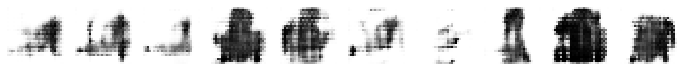

d_loss: 0.059892   g_loss: 0.252451
Epochs 2: 

  0%|          | 0/273 [00:00<?, ?it/s]

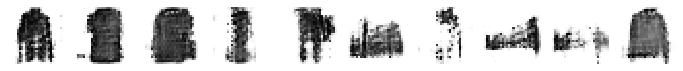

d_loss: 0.065311   g_loss: 0.225667
Epochs 3: 

  0%|          | 0/273 [00:00<?, ?it/s]

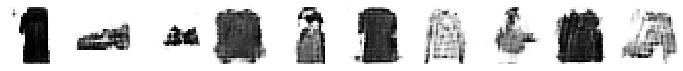

d_loss: 0.070022   g_loss: 0.235765
Epochs 4: 

  0%|          | 0/273 [00:00<?, ?it/s]

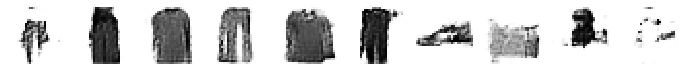

d_loss: 0.073373   g_loss: 0.241779
Epochs 5: 

  0%|          | 0/273 [00:00<?, ?it/s]

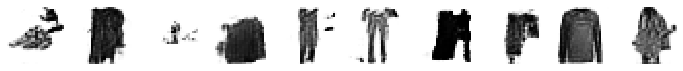

d_loss: 0.075341   g_loss: 0.243088
Epochs 6: 

  0%|          | 0/273 [00:00<?, ?it/s]

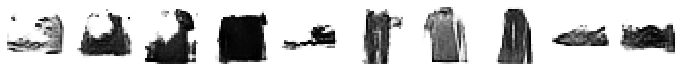

d_loss: 0.075909   g_loss: 0.246111
Epochs 7: 

  0%|          | 0/273 [00:00<?, ?it/s]

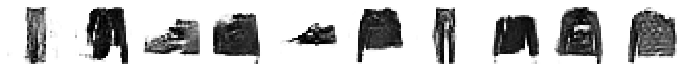

d_loss: 0.076100   g_loss: 0.251647
Epochs 8: 

  0%|          | 0/273 [00:00<?, ?it/s]

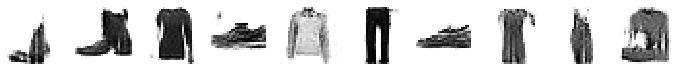

d_loss: 0.076076   g_loss: 0.252556
Epochs 9: 

  0%|          | 0/273 [00:00<?, ?it/s]

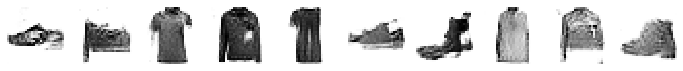

d_loss: 0.076131   g_loss: 0.254294
Epochs 10: 

  0%|          | 0/273 [00:00<?, ?it/s]

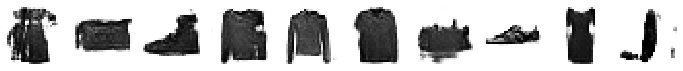

d_loss: 0.075871   g_loss: 0.256973
Epochs 11: 

  0%|          | 0/273 [00:00<?, ?it/s]

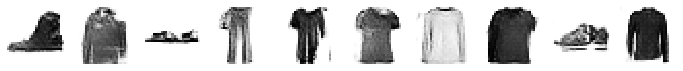

d_loss: 0.075608   g_loss: 0.256224
Epochs 12: 

  0%|          | 0/273 [00:00<?, ?it/s]

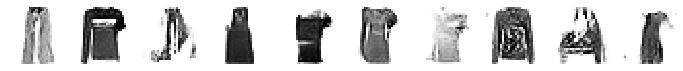

d_loss: 0.075480   g_loss: 0.257284
Epochs 13: 

  0%|          | 0/273 [00:00<?, ?it/s]

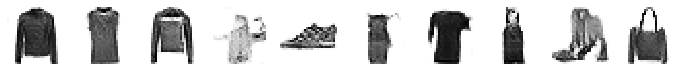

d_loss: 0.075418   g_loss: 0.260820
Epochs 14: 

  0%|          | 0/273 [00:00<?, ?it/s]

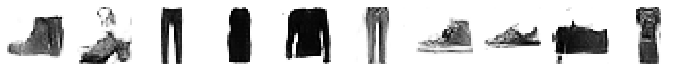

d_loss: 0.075467   g_loss: 0.264089
Epochs 15: 

  0%|          | 0/273 [00:00<?, ?it/s]

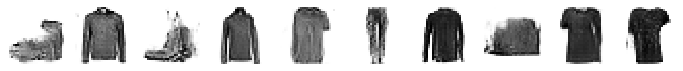

d_loss: 0.075399   g_loss: 0.262838
Epochs 16: 

  0%|          | 0/273 [00:00<?, ?it/s]

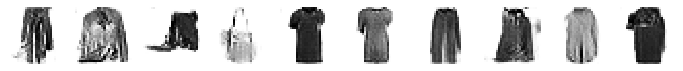

d_loss: 0.075484   g_loss: 0.265920
Epochs 17: 

  0%|          | 0/273 [00:00<?, ?it/s]

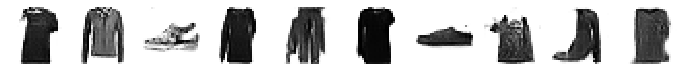

d_loss: 0.075522   g_loss: 0.267435
Epochs 18: 

  0%|          | 0/273 [00:00<?, ?it/s]

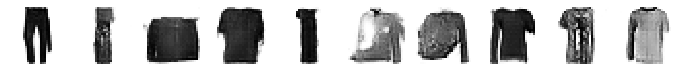

d_loss: 0.075395   g_loss: 0.270490
Epochs 19: 

  0%|          | 0/273 [00:00<?, ?it/s]

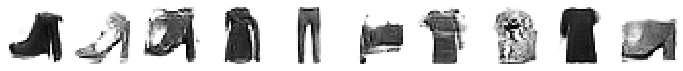

d_loss: 0.075395   g_loss: 0.270672
Epochs 20: 

  0%|          | 0/273 [00:00<?, ?it/s]

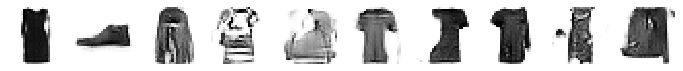

d_loss: 0.075461   g_loss: 0.274425
Epochs 21: 

  0%|          | 0/273 [00:00<?, ?it/s]

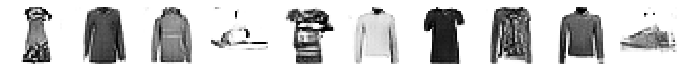

d_loss: 0.075468   g_loss: 0.273959
Epochs 22: 

  0%|          | 0/273 [00:00<?, ?it/s]

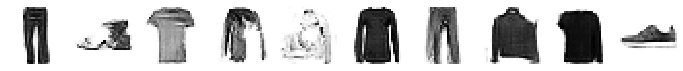

d_loss: 0.075391   g_loss: 0.275563
Epochs 23: 

  0%|          | 0/273 [00:00<?, ?it/s]

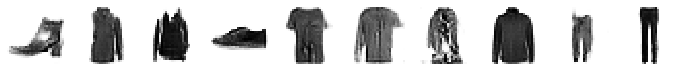

d_loss: 0.075239   g_loss: 0.277160
Epochs 24: 

  0%|          | 0/273 [00:00<?, ?it/s]

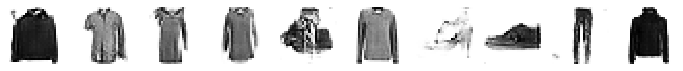

d_loss: 0.075455   g_loss: 0.278962
Epochs 25: 

  0%|          | 0/273 [00:00<?, ?it/s]

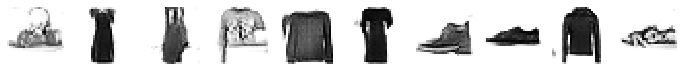

d_loss: 0.075473   g_loss: 0.277774
Epochs 26: 

  0%|          | 0/273 [00:00<?, ?it/s]

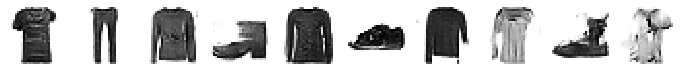

d_loss: 0.075395   g_loss: 0.279946
Epochs 27: 

  0%|          | 0/273 [00:00<?, ?it/s]

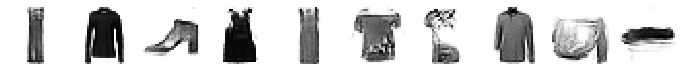

d_loss: 0.075257   g_loss: 0.278867
Epochs 28: 

  0%|          | 0/273 [00:00<?, ?it/s]

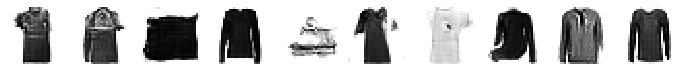

d_loss: 0.075214   g_loss: 0.281162
Epochs 29: 

  0%|          | 0/273 [00:00<?, ?it/s]

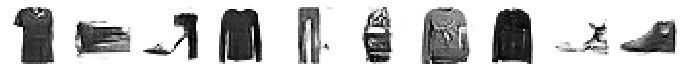

d_loss: 0.075220   g_loss: 0.281820
Epochs 30: 

  0%|          | 0/273 [00:00<?, ?it/s]

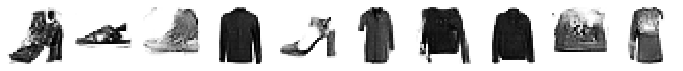

d_loss: 0.075226   g_loss: 0.283058
Epochs 31: 

  0%|          | 0/273 [00:00<?, ?it/s]

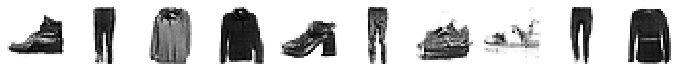

d_loss: 0.075189   g_loss: 0.282640
Epochs 32: 

  0%|          | 0/273 [00:00<?, ?it/s]

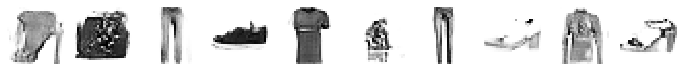

d_loss: 0.075333   g_loss: 0.283281
Epochs 33: 

  0%|          | 0/273 [00:00<?, ?it/s]

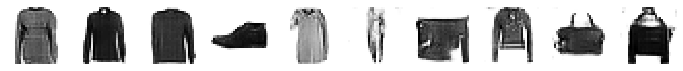

d_loss: 0.075320   g_loss: 0.281986
Epochs 34: 

  0%|          | 0/273 [00:00<?, ?it/s]

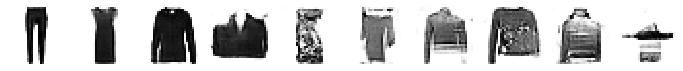

d_loss: 0.075115   g_loss: 0.282720
Epochs 35: 

  0%|          | 0/273 [00:00<?, ?it/s]

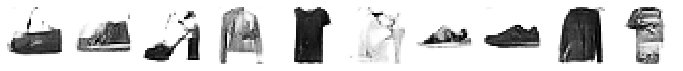

d_loss: 0.075199   g_loss: 0.282523
Epochs 36: 

  0%|          | 0/273 [00:00<?, ?it/s]

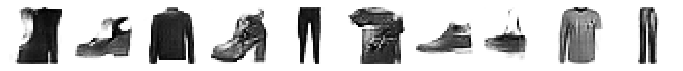

d_loss: 0.075023   g_loss: 0.284300
Epochs 37: 

  0%|          | 0/273 [00:00<?, ?it/s]

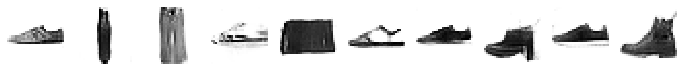

d_loss: 0.075058   g_loss: 0.285273
Epochs 38: 

  0%|          | 0/273 [00:00<?, ?it/s]

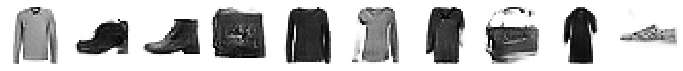

d_loss: 0.074997   g_loss: 0.285603
Epochs 39: 

  0%|          | 0/273 [00:00<?, ?it/s]

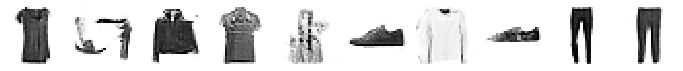

d_loss: 0.074931   g_loss: 0.284629
Epochs 40: 

  0%|          | 0/273 [00:00<?, ?it/s]

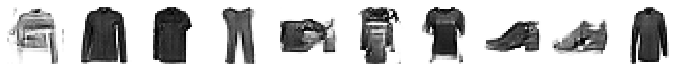

d_loss: 0.074830   g_loss: 0.285130
Epochs 41: 

  0%|          | 0/273 [00:00<?, ?it/s]

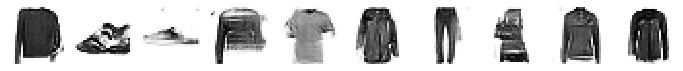

d_loss: 0.074927   g_loss: 0.285975
Epochs 42: 

  0%|          | 0/273 [00:00<?, ?it/s]

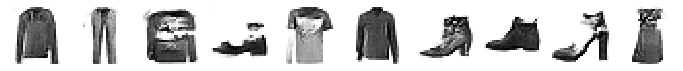

d_loss: 0.074765   g_loss: 0.286396
Epochs 43: 

  0%|          | 0/273 [00:00<?, ?it/s]

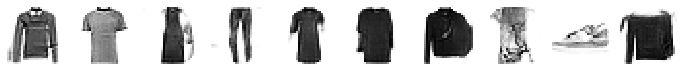

d_loss: 0.074906   g_loss: 0.286808
Epochs 44: 

  0%|          | 0/273 [00:00<?, ?it/s]

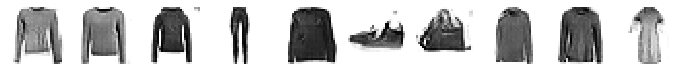

d_loss: 0.074813   g_loss: 0.284892
Epochs 45: 

  0%|          | 0/273 [00:00<?, ?it/s]

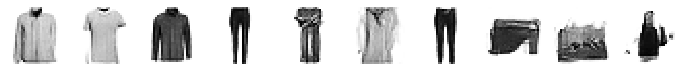

d_loss: 0.074854   g_loss: 0.285665
Epochs 46: 

  0%|          | 0/273 [00:00<?, ?it/s]

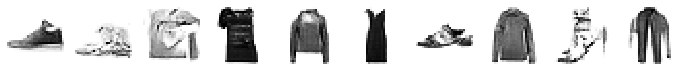

d_loss: 0.074765   g_loss: 0.288501
Epochs 47: 

  0%|          | 0/273 [00:00<?, ?it/s]

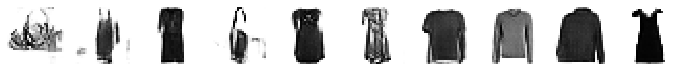

d_loss: 0.074872   g_loss: 0.288015
Epochs 48: 

  0%|          | 0/273 [00:00<?, ?it/s]

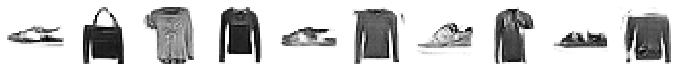

d_loss: 0.074854   g_loss: 0.287303
Epochs 49: 

  0%|          | 0/273 [00:00<?, ?it/s]

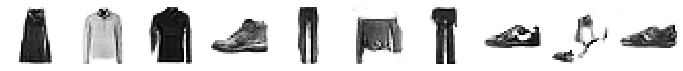

d_loss: 0.074756   g_loss: 0.287308
Epochs 50: 

  0%|          | 0/273 [00:00<?, ?it/s]

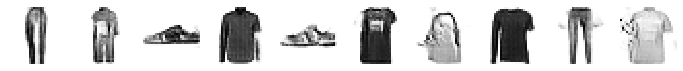

d_loss: 0.074591   g_loss: 0.288559
Epochs 51: 

  0%|          | 0/273 [00:00<?, ?it/s]

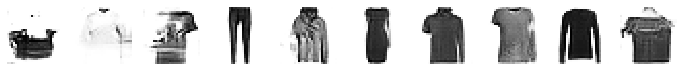

d_loss: 0.074646   g_loss: 0.289364
Epochs 52: 

  0%|          | 0/273 [00:00<?, ?it/s]

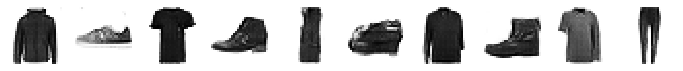

d_loss: 0.074688   g_loss: 0.287947
Epochs 53: 

  0%|          | 0/273 [00:00<?, ?it/s]

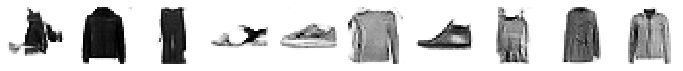

d_loss: 0.074614   g_loss: 0.288963
Epochs 54: 

  0%|          | 0/273 [00:00<?, ?it/s]

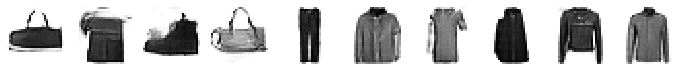

d_loss: 0.074591   g_loss: 0.287439
Epochs 55: 

  0%|          | 0/273 [00:00<?, ?it/s]

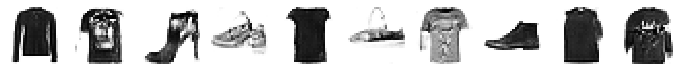

d_loss: 0.074511   g_loss: 0.288348
Epochs 56: 

  0%|          | 0/273 [00:00<?, ?it/s]

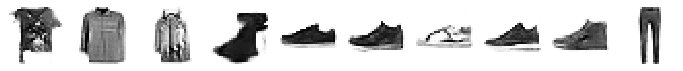

d_loss: 0.074384   g_loss: 0.288898
Epochs 57: 

  0%|          | 0/273 [00:00<?, ?it/s]

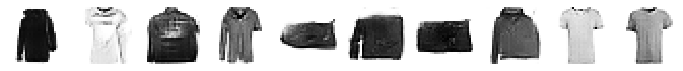

d_loss: 0.074566   g_loss: 0.289056
Epochs 58: 

  0%|          | 0/273 [00:00<?, ?it/s]

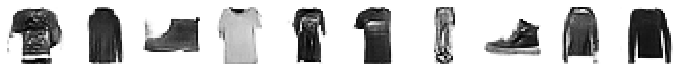

d_loss: 0.074479   g_loss: 0.289373
Epochs 59: 

  0%|          | 0/273 [00:00<?, ?it/s]

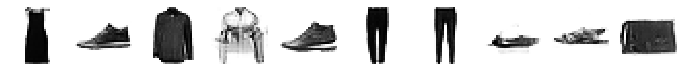

d_loss: 0.074561   g_loss: 0.288606
Epochs 60: 

  0%|          | 0/273 [00:00<?, ?it/s]

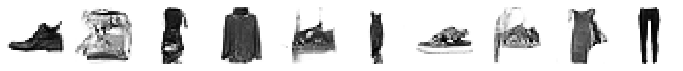

d_loss: 0.074340   g_loss: 0.288800
Epochs 61: 

  0%|          | 0/273 [00:00<?, ?it/s]

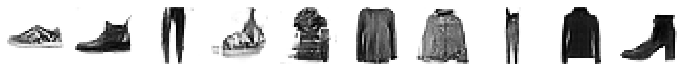

d_loss: 0.074432   g_loss: 0.288554
Epochs 62: 

  0%|          | 0/273 [00:00<?, ?it/s]

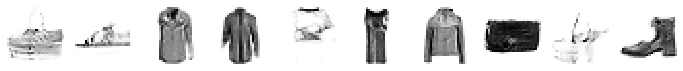

d_loss: 0.074382   g_loss: 0.290218
Epochs 63: 

  0%|          | 0/273 [00:00<?, ?it/s]

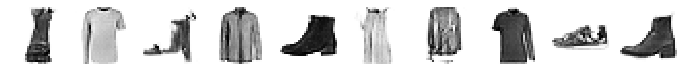

d_loss: 0.074284   g_loss: 0.288315
Epochs 64: 

  0%|          | 0/273 [00:00<?, ?it/s]

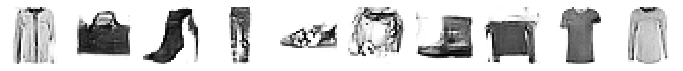

d_loss: 0.074362   g_loss: 0.289377
Epochs 65: 

  0%|          | 0/273 [00:00<?, ?it/s]

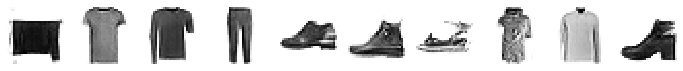

d_loss: 0.074299   g_loss: 0.290666
Epochs 66: 

  0%|          | 0/273 [00:00<?, ?it/s]

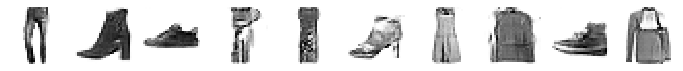

d_loss: 0.074182   g_loss: 0.289815
Epochs 67: 

  0%|          | 0/273 [00:00<?, ?it/s]

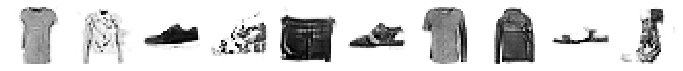

d_loss: 0.074305   g_loss: 0.288882
Epochs 68: 

  0%|          | 0/273 [00:00<?, ?it/s]

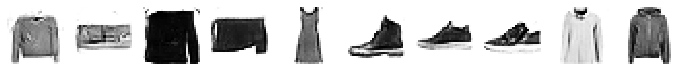

d_loss: 0.074187   g_loss: 0.288755
Epochs 69: 

  0%|          | 0/273 [00:00<?, ?it/s]

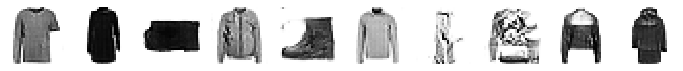

d_loss: 0.074039   g_loss: 0.290713
Epochs 70: 

  0%|          | 0/273 [00:00<?, ?it/s]

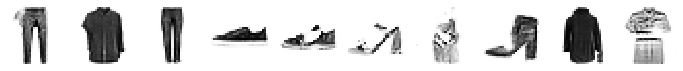

d_loss: 0.074010   g_loss: 0.288774
Epochs 71: 

  0%|          | 0/273 [00:00<?, ?it/s]

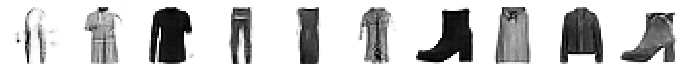

d_loss: 0.073938   g_loss: 0.290420
Epochs 72: 

  0%|          | 0/273 [00:00<?, ?it/s]

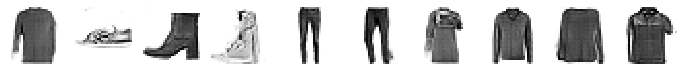

d_loss: 0.073888   g_loss: 0.290054
Epochs 73: 

  0%|          | 0/273 [00:00<?, ?it/s]

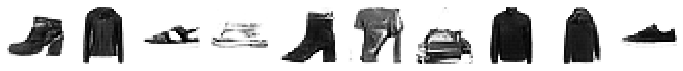

d_loss: 0.073737   g_loss: 0.289785
Epochs 74: 

  0%|          | 0/273 [00:00<?, ?it/s]

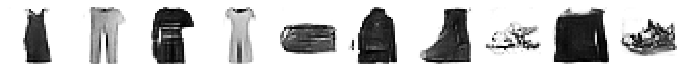

d_loss: 0.073835   g_loss: 0.289329
Epochs 75: 

  0%|          | 0/273 [00:00<?, ?it/s]

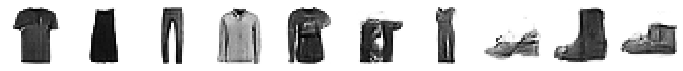

d_loss: 0.073692   g_loss: 0.291186
Epochs 76: 

  0%|          | 0/273 [00:00<?, ?it/s]

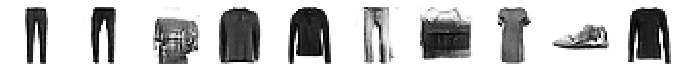

d_loss: 0.073650   g_loss: 0.289842
Epochs 77: 

  0%|          | 0/273 [00:00<?, ?it/s]

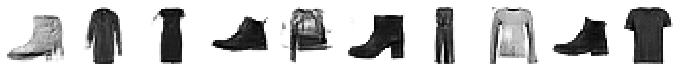

d_loss: 0.073846   g_loss: 0.292043
Epochs 78: 

  0%|          | 0/273 [00:00<?, ?it/s]

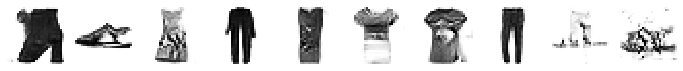

d_loss: 0.073499   g_loss: 0.290542
Epochs 79: 

  0%|          | 0/273 [00:00<?, ?it/s]

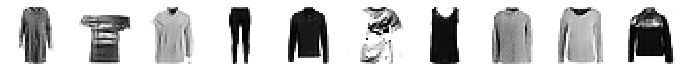

d_loss: 0.073580   g_loss: 0.289624
Epochs 80: 

  0%|          | 0/273 [00:00<?, ?it/s]

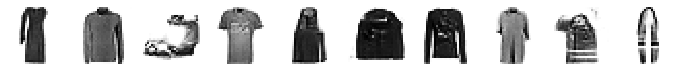

d_loss: 0.073598   g_loss: 0.290127
Epochs 81: 

  0%|          | 0/273 [00:00<?, ?it/s]

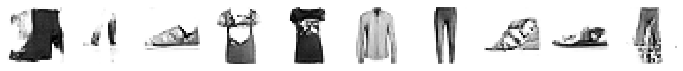

d_loss: 0.073512   g_loss: 0.292010
Epochs 82: 

  0%|          | 0/273 [00:00<?, ?it/s]

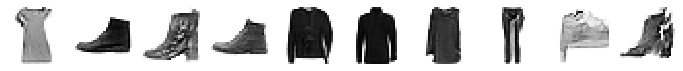

d_loss: 0.073307   g_loss: 0.290502
Epochs 83: 

  0%|          | 0/273 [00:00<?, ?it/s]

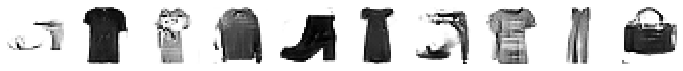

d_loss: 0.073544   g_loss: 0.290535
Epochs 84: 

  0%|          | 0/273 [00:00<?, ?it/s]

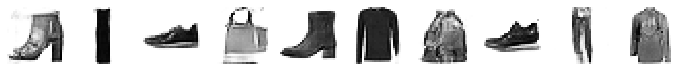

d_loss: 0.073539   g_loss: 0.290900
Epochs 85: 

  0%|          | 0/273 [00:00<?, ?it/s]

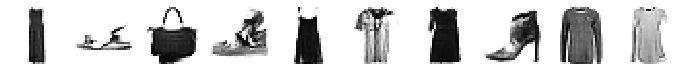

d_loss: 0.073405   g_loss: 0.291275
Epochs 86: 

  0%|          | 0/273 [00:00<?, ?it/s]

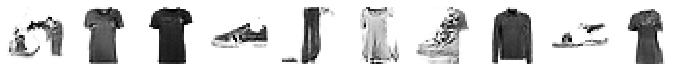

d_loss: 0.073529   g_loss: 0.290607
Epochs 87: 

  0%|          | 0/273 [00:00<?, ?it/s]

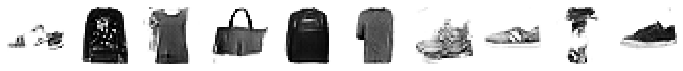

d_loss: 0.073346   g_loss: 0.291288
Epochs 88: 

  0%|          | 0/273 [00:00<?, ?it/s]

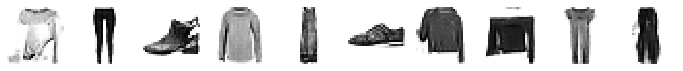

d_loss: 0.073227   g_loss: 0.290998
Epochs 89: 

  0%|          | 0/273 [00:00<?, ?it/s]

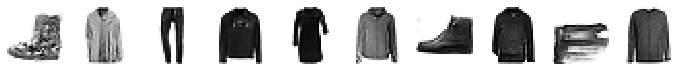

d_loss: 0.073205   g_loss: 0.291448
Epochs 90: 

  0%|          | 0/273 [00:00<?, ?it/s]

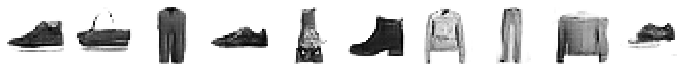

d_loss: 0.073283   g_loss: 0.290341
Epochs 91: 

  0%|          | 0/273 [00:00<?, ?it/s]

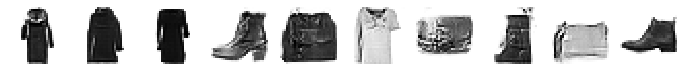

d_loss: 0.073170   g_loss: 0.290951
Epochs 92: 

  0%|          | 0/273 [00:00<?, ?it/s]

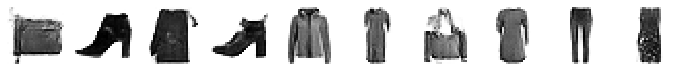

d_loss: 0.073122   g_loss: 0.289851
Epochs 93: 

  0%|          | 0/273 [00:00<?, ?it/s]

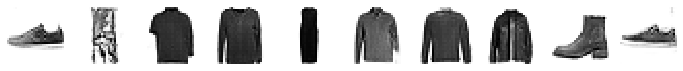

d_loss: 0.073272   g_loss: 0.289563
Epochs 94: 

  0%|          | 0/273 [00:00<?, ?it/s]

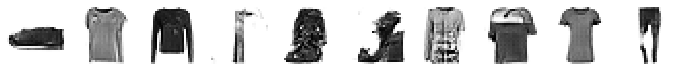

d_loss: 0.073120   g_loss: 0.291871
Epochs 95: 

  0%|          | 0/273 [00:00<?, ?it/s]

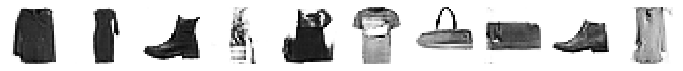

d_loss: 0.072959   g_loss: 0.291472
Epochs 96: 

  0%|          | 0/273 [00:00<?, ?it/s]

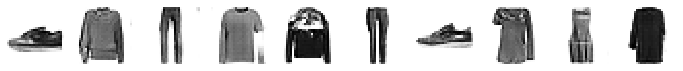

d_loss: 0.073037   g_loss: 0.289629
Epochs 97: 

  0%|          | 0/273 [00:00<?, ?it/s]

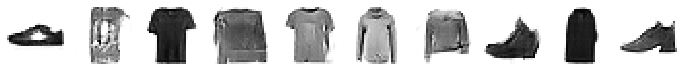

d_loss: 0.072867   g_loss: 0.289478
Epochs 98: 

  0%|          | 0/273 [00:00<?, ?it/s]

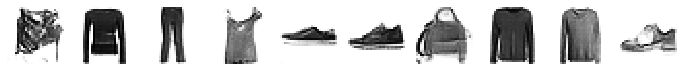

d_loss: 0.072861   g_loss: 0.290788
Epochs 99: 

  0%|          | 0/273 [00:00<?, ?it/s]

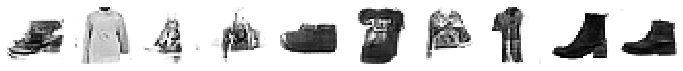

d_loss: 0.072858   g_loss: 0.292270
Epochs 100: 

  0%|          | 0/273 [00:00<?, ?it/s]

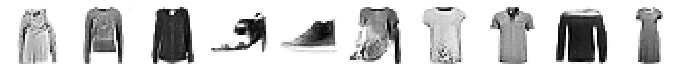

d_loss: 0.072572   g_loss: 0.291866


In [13]:
train(gan_model, data)

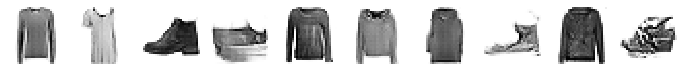

In [14]:
show_example(gan_model)

In [15]:
gan_model.save('gan_fashionmnist.h5')